- Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
- Apply a distortion correction to raw images.
- Use color transforms, gradients, etc., to create a thresholded binary image.
- Apply a perspective transform to rectify binary image ("birds-eye view").
- Detect lane pixels and fit to find the lane boundary.
- Determine the curvature of the lane and vehicle position with respect to center.
- Warp the detected lane boundaries back onto the original image.
- Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [1]:
!ls

camera_cal		    main.ipynb		  README.md
challenge_video.mp4	    output_challenge.mp4  set_git.sh
examples		    output_harder.mp4	  test_images
example_writeup.pdf	    output_images	  writeup_template.md
harder_challenge_video.mp4  project_output.mp4
LICENSE			    project_video.mp4


In [2]:
!ls camera_cal/

calibration10.jpg  calibration15.jpg  calibration1.jpg	 calibration5.jpg
calibration11.jpg  calibration16.jpg  calibration20.jpg  calibration6.jpg
calibration12.jpg  calibration17.jpg  calibration2.jpg	 calibration7.jpg
calibration13.jpg  calibration18.jpg  calibration3.jpg	 calibration8.jpg
calibration14.jpg  calibration19.jpg  calibration4.jpg	 calibration9.jpg


### 1. Compute Camera Calibration

In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2

nx = 9
ny = 6

In [2]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
# Will be appended each time we find corners
objp = np.zeros((ny*nx,3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

for f in os.listdir('./camera_cal'):
    img = mpimg.imread("./camera_cal/{}".format(f))
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    if ret:
        objpoints.append(objp)
        imgpoints.append(corners)
        
#         fig, ax = plt.subplots()
#         img = cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
#         plt.imshow(img)
#         plt.title(f)

### 2. Apply undistort

In [3]:
# Calibrate camera
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

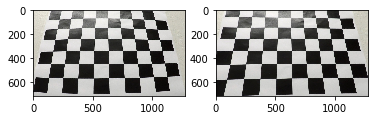

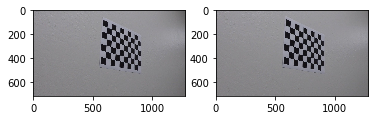

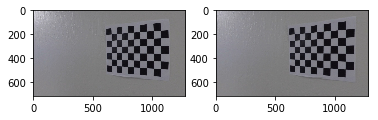

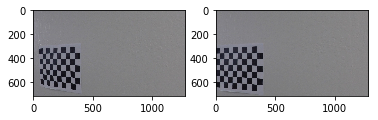

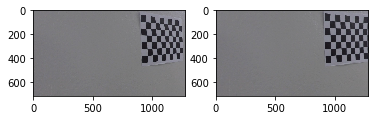

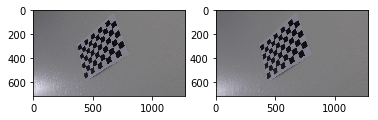

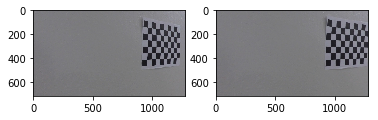

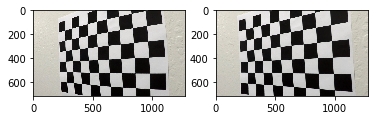

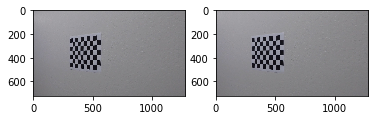

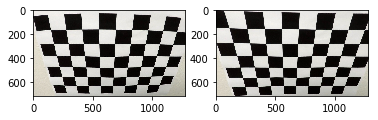

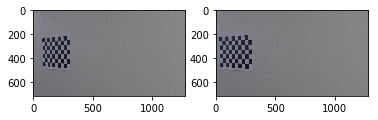

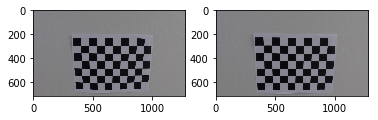

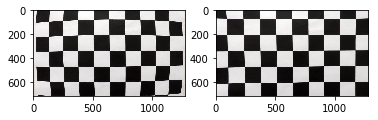

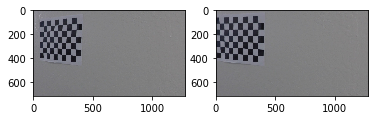

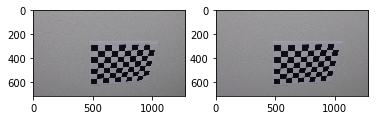

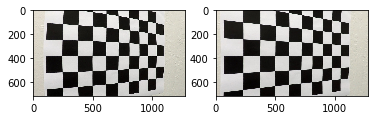

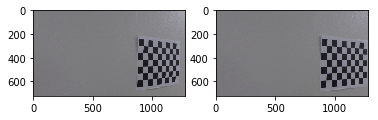

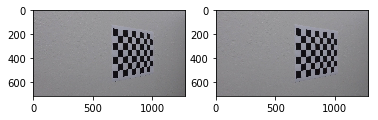

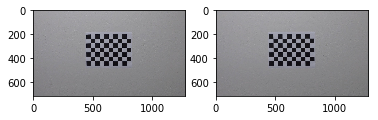

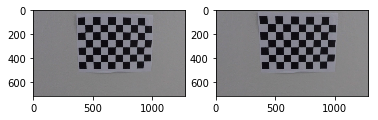

In [4]:
# Apply undistort to all files
for f in os.listdir('./camera_cal'):
    img = mpimg.imread('./camera_cal/{}'.format(f))
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    fig, (ax1, ax2) = plt.subplots(1,2)
    ax1.imshow(img)
    ax2.imshow(dst)

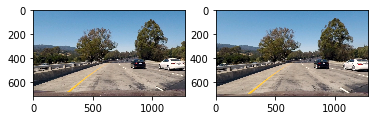

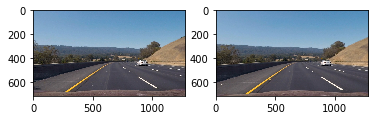

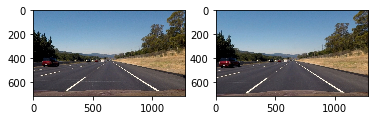

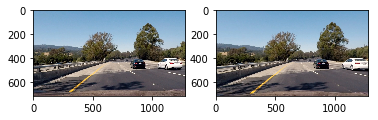

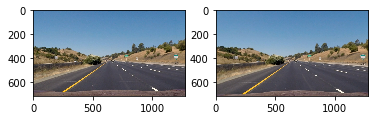

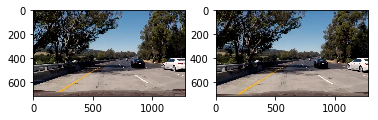

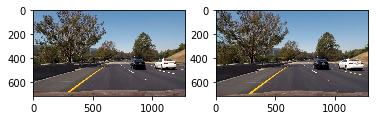

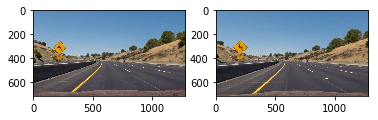

In [5]:
# Apply undistort to all files
UNDIST_IMGS = []

for f in os.listdir('./test_images'):
    img = mpimg.imread('./test_images/{}'.format(f))
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    UNDIST_IMGS.append(dst)
    fig, (ax1, ax2) = plt.subplots(1,2)
    ax1.imshow(img)
    ax2.imshow(dst)

In [6]:
def undistort(img):
    return cv2.undistort(img, mtx, dist, None, mtx)

### 3. Use color transforms, gradients, etc., to create a thresholded binary image.

In [7]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(50,255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel > thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    # Return the result
    return binary_output

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag > mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output


def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir > thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

def hls_select(img, thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    return binary_output

In [8]:
# Choose a Sobel kernel size
ksize = 15 # Choose a larger odd number to smooth gradient measurements

# Apply each of the thresholding functions
timg = mpimg.imread('./test_images/straight_lines2.jpg')
timg = undistort(timg)
gradx = abs_sobel_thresh(timg, orient='x', sobel_kernel=ksize, thresh=(50, 255))
grady = abs_sobel_thresh(timg, orient='y', sobel_kernel=ksize, thresh=(50, 255))
mag_binary = mag_thresh(timg, sobel_kernel=ksize, mag_thresh=(50, 255))
dir_binary = dir_threshold(timg, sobel_kernel=ksize, thresh=(1, np.pi/2))
hls_binary = hls_select(timg, thresh=(100, 255))

Text(0.5,1,'S channel')

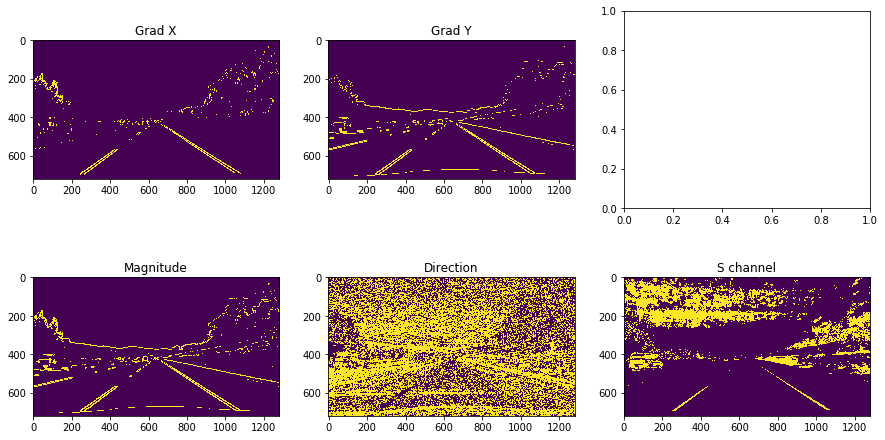

In [9]:
fig, ax = plt.subplots(2, 3, figsize=(15,8))
ax[0][0].imshow(gradx)
ax[0][0].set_title("Grad X")
ax[0][1].imshow(grady)
ax[0][1].set_title("Grad Y")
ax[1][0].imshow(mag_binary)
ax[1][0].set_title("Magnitude")
ax[1][1].imshow(dir_binary)
ax[1][1].set_title("Direction")
ax[1][2].imshow(hls_binary)
ax[1][2].set_title("S channel")

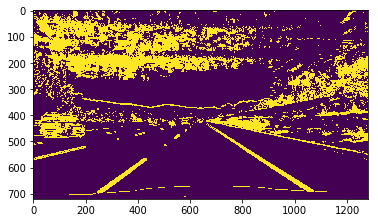

In [22]:
combined = np.zeros_like(dir_binary)
combined[((gradx == 1) & (grady == 1))] = 1
combined[((mag_binary == 1) & (dir_binary == 1))] = 1
combined[(hls_binary == 1)] = 1

plt.imshow(combined)

In [10]:
def get_binary(timg):
    gradx = abs_sobel_thresh(timg, orient='x', sobel_kernel=ksize, thresh=(50, 255))
    grady = abs_sobel_thresh(timg, orient='y', sobel_kernel=ksize, thresh=(50, 255))
    mag_binary = mag_thresh(timg, sobel_kernel=ksize, mag_thresh=(50, 255))
    dir_binary = dir_threshold(timg, sobel_kernel=ksize, thresh=(1, np.pi/2))
    hls_binary = hls_select(timg, thresh=(100, 255))
    
    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1))] = 1
    combined[((mag_binary == 1) & (dir_binary == 1))] = 1
    combined[(hls_binary == 1)] = 1

    return combined

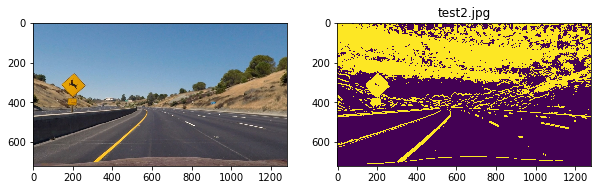

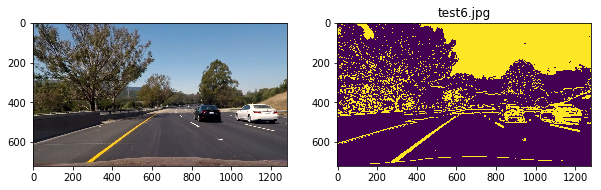

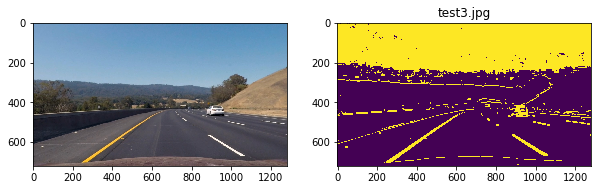

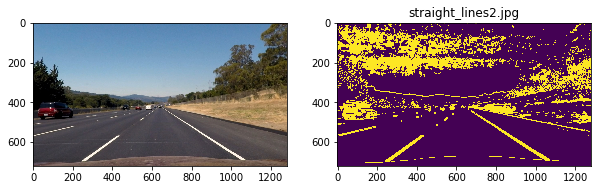

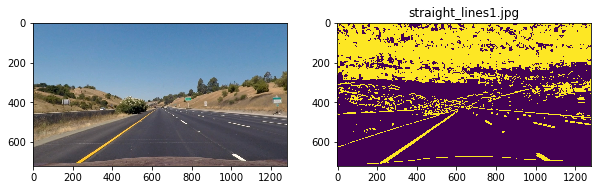

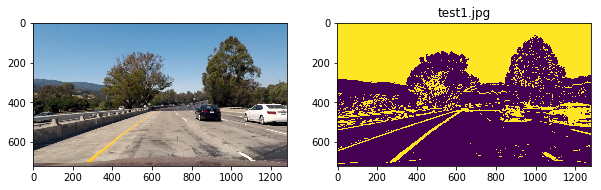

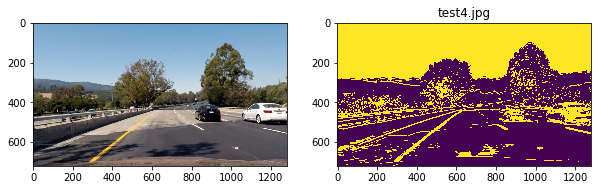

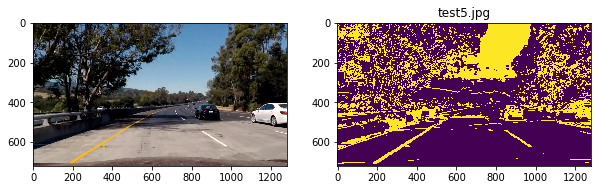

In [24]:
for f in os.listdir('./test_images'):
    filename = './test_images/{}'.format(f)
    fig, ax = plt.subplots(1,2, figsize=(10, 7))
    xx = mpimg.imread(filename)
    xx = undistort(xx)
    yy = get_binary(xx)
    ax[0].imshow(xx)
    ax[1].imshow(yy)
    plt.title(f)

### 4. Apply perspective transform

In [11]:
def birds_eye(image, src, offset=50):
    img_size = (image.shape[1], image.shape[0])
    #src = np.array([[700,230],[700,1080], [500,775],[500,515]], np.float32)
    dst = np.float32([[offset, offset], [img_size[0]-offset, offset], 
                                     [img_size[0]-offset, img_size[1]-offset], 
                                     [offset, img_size[1]-offset]])
    
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(image, M, img_size, flags=cv2.INTER_LINEAR)
    return warped

In [12]:
def inverse_birds_eye(image, src, offset=50):
    img_size = (image.shape[1], image.shape[0])
    dst = np.float32([[offset, offset], 
                      [img_size[0]-offset, offset], 
                      [img_size[0]-offset, img_size[1]-offset], 
                      [offset, img_size[1]-offset]])
    
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(image, Minv, img_size, flags=cv2.INTER_LINEAR)
    return warped

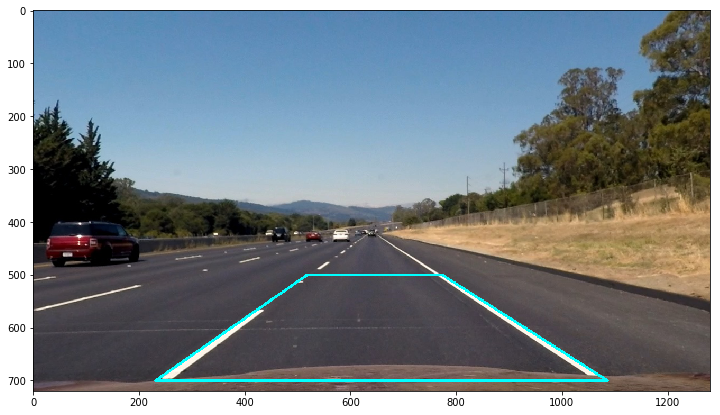

In [13]:
timg = mpimg.imread('./test_images/straight_lines2.jpg')
timg = undistort(timg)

draw_copy = timg.copy()
pts = np.array([[518,500],
                [773,500],
                [1086,700],
                [231,700],
               ], np.int32)
pts = pts.reshape((-1,1,2))
cv2.polylines(draw_copy, [pts], True, (0,255,255), thickness=3)
fig, ax = plt.subplots(figsize=(15, 7))
plt.imshow(draw_copy)

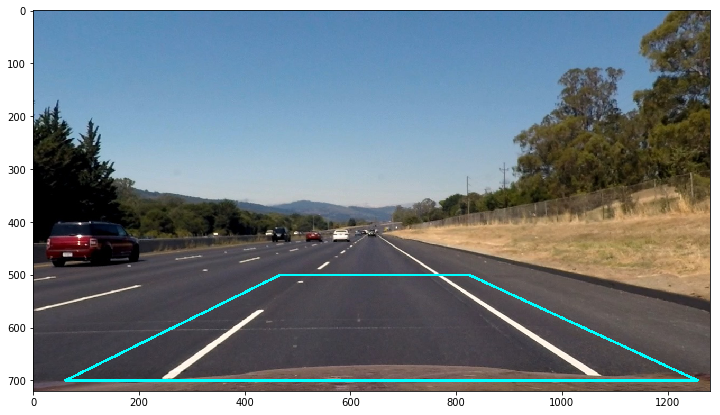

In [14]:
# Shift the source points parallel outwards so we can capture a bigger frame
upper_line_width = 773-518
bottom_line_width = 1086-231
ppts = np.array([[518-upper_line_width*0.2,500],
                [773+upper_line_width*0.2,500],
                [1086+bottom_line_width*0.2,700],
                [231-bottom_line_width*0.2,700],
               ], np.int32)
ppts = ppts.reshape((-1,1,2))

# plot again
timg = mpimg.imread('./test_images/straight_lines2.jpg')
timg = undistort(timg)
draw_copy = timg.copy()
cv2.polylines(draw_copy, [ppts], True, (0,255,255), thickness=3)
fig, ax = plt.subplots(figsize=(15, 7))
plt.imshow(draw_copy)

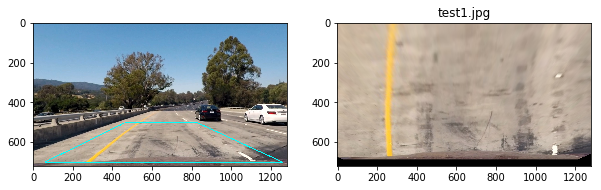

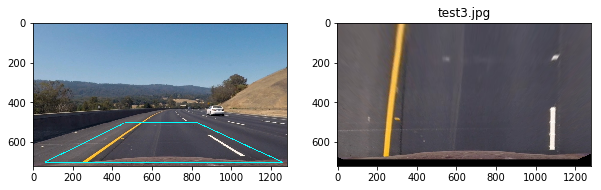

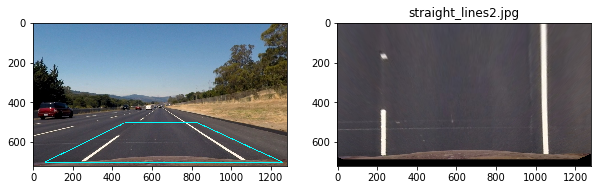

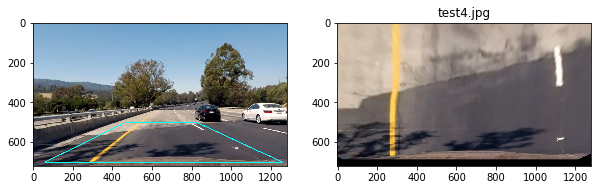

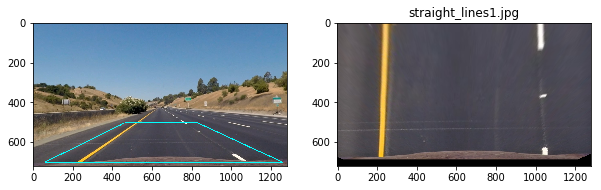

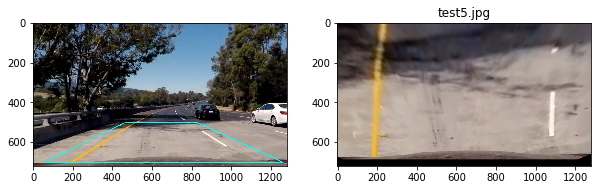

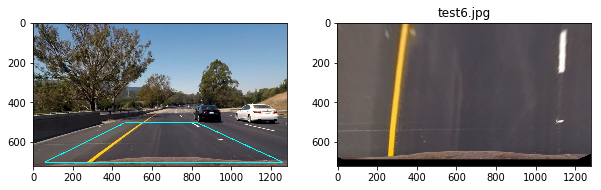

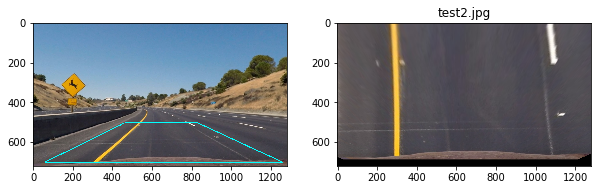

In [15]:
# Define source
src = np.float32(ppts)

for f in os.listdir('./test_images'):
    timg = mpimg.imread('./test_images/{}'.format(f))
    timg = undistort(timg)
    beimg = birds_eye(timg, src)
    pts = np.int32(src).reshape((-1,1,2))
    cv2.polylines(timg, [pts], True, (0,255,255), thickness=3)
    fig, ax = plt.subplots(1,2, figsize=(10, 6))
    ax[0].imshow(timg)
    ax[1].imshow(beimg)
    plt.title(f)

### 5. Detect lane pixels and fit to find the lane boundary

In [12]:
def _find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    out_img = out_img * 255
    out_img = np.uint8(out_img)
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix_recenter = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,
                      (win_xleft_low,win_y_low),
                      (win_xleft_high,win_y_high),
                      (0,255,0), 2) 
        cv2.rectangle(out_img,
                      (win_xright_low,win_y_low),
                      (win_xright_high,win_y_high),
                      (255,0,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix_recenter:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix_recenter:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


def _fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = _find_lane_pixels(binary_warped)

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')

    return out_img, left_fitx, right_fitx, ploty

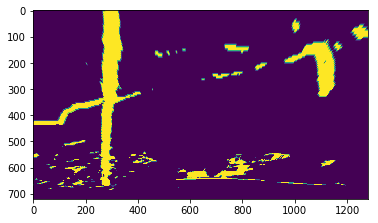

In [59]:
timg = mpimg.imread('./test_images/test4.jpg')
undst = undistort(timg)
binary = get_binary(undst)
bebin = birds_eye(binary, src)
plt.imshow(bebin)

In [60]:
out, left_x, right_x, plot_y = _fit_polynomial(bebin)
plt.imshow(out)

NameError: name '_fit_polynomial' is not defined

In [13]:
def _fit_poly(img_shape, leftx, lefty, rightx, righty):
    
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
      
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fitx, right_fitx, ploty

In [14]:
def _search_around_poly(binary_warped, prev_left_fit, prev_right_fit):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 100

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### TO-DO: Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    left_lane_inds = ((nonzerox > (prev_left_fit[0]*(nonzeroy**2) + prev_left_fit[1]*nonzeroy + 
                    prev_left_fit[2] - margin)) & (nonzerox < (prev_left_fit[0]*(nonzeroy**2) + 
                    prev_left_fit[1]*nonzeroy + prev_left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (prev_right_fit[0]*(nonzeroy**2) + prev_right_fit[1]*nonzeroy + 
                    prev_right_fit[2] - margin)) & (nonzerox < (prev_right_fit[0]*(nonzeroy**2) + 
                    prev_right_fit[1]*nonzeroy + prev_right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fitx, right_fitx, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    prev_left_fitx = prev_left_fit[0]*ploty**2 + prev_left_fit[1]*ploty + prev_left_fit[2]
    prev_right_fitx = prev_right_fit[0]*ploty**2 + prev_right_fit[1]*ploty + prev_right_fit[2]
    
    left_line_window1 = np.array([np.transpose(np.vstack([prev_left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([prev_left_fitx+margin, ploty])))])
    prev_left_line_pts = np.hstack((left_line_window1, left_line_window2))
    
    right_line_window1 = np.array([np.transpose(np.vstack([prev_right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([prev_right_fitx+margin, ploty])))])
    prev_right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([prev_left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([prev_right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    # Plot the polynomial lines onto the image
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    ## End visualization steps ##
    
    return result

In [15]:
# # Get prev fit
# leftx, lefty, rightx, righty, out_img = find_lane_pixels(bebin)
# prev_left_fit = np.polyfit(lefty, leftx, 2)
# prev_right_fit = np.polyfit(righty, rightx, 2)

# # Get new image bebin
# newImage = mpimg.imread('./test_images/test3.jpg')
# newUndst = undistort(newImage)
# newBinary = get_binary(newUndst)
# newBebin = birds_eye(newBinary, src)
# search_around = search_around_poly(newBebin, prev_left_fit, prev_right_fit)
# plt.imshow(search_around)

### main

In [125]:
import numpy as np


def sliding_window_pixels(binary_warped, draw_intermediate):
    """
    Finds pixels by determining middle points and then using sliding windows
    """
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)

    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0] // 2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    nwindows = 9  # Choose the number of sliding windows
    margin = 100  # Set the width of the windows +/- margin
    minpix = 50  # Set minimum number of pixels found to re-center window

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0] // nwindows)

    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Create empty image
    out_img = np.dstack((binary_warped, binary_warped, binary_warped)) * 255
    out_img = np.uint8(out_img)

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window + 1) * window_height
        win_y_high = binary_warped.shape[0] - window * window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
    
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,
                      (win_xleft_low,win_y_low),
                      (win_xleft_high,win_y_high),
                      (0,255,0), 2) 
        cv2.rectangle(out_img,
                      (win_xright_low,win_y_low),
                      (win_xright_high,win_y_high),
                      (255,0,0), 2) 

        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]

        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)

        # If you found > minpix pixels, re-center next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    if draw_intermediate:
        fig, ax = plt.subplots()
        plt.imshow(out_img)
        plt.title("sliding windows!")

    return leftx, lefty, rightx, righty


def get_indexes_around_poly(nonzeroy, nonzerox, prev_poly, margin):
    b2, b1, c = prev_poly
    greater_than = (nonzerox > (b2 * (nonzeroy**2) + b1 * nonzeroy + c - margin))
    less_than = (nonzerox < (b2 * (nonzeroy**2) + b1 * nonzeroy + c + margin))
    return greater_than & less_than


def get_x_and_y(img_shape, left_poly, right_poly):
    ploty = np.linspace(0, img_shape[0] - 1, img_shape[0])
    fitted_left_x = left_poly[0] * ploty**2 + left_poly[1] * ploty + left_poly[2]
    fitted_right_x = right_poly[0] * ploty**2 + right_poly[1] * ploty + right_poly[2]

    return fitted_left_x, fitted_right_x, ploty


def find_lane_pixels(binary_warped, prev_left_poly, prev_right_poly,
                     prev_left_points, prev_right_points,
                     margin, add_points_margin=None, draw_intermediate=False):
    """
    Args:
        prev_left_points (tuple): should be type (prev_img_leftx, prev_img_lefty)
    """
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped)) * 255
    out_img = np.uint8(out_img)

    # First grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    # Get the correct pixels based on (a) prev poly or (b) sliding window
    if (prev_left_poly != None) & (prev_right_poly != None):
        left_lane_inds = get_indexes_around_poly(nonzeroy, nonzerox, prev_left_poly, margin)
        right_lane_inds = get_indexes_around_poly(nonzeroy, nonzerox, prev_right_poly, margin)
        img_leftx = nonzerox[left_lane_inds]
        img_lefty = nonzeroy[left_lane_inds]
        img_rightx = nonzerox[right_lane_inds]
        img_righty = nonzeroy[right_lane_inds]
    else:
        img_leftx, img_lefty, img_rightx, img_righty = sliding_window_pixels(binary_warped, draw_intermediate)

    # Add extra points within a narrow margin
    if add_points_margin:
        if (prev_left_points != None) & (prev_right_points != None):
            prev_left_inds = get_indexes_around_poly(prev_left_points[1], prev_left_points[0], prev_left_poly, add_points_margin)
            prev_right_inds = get_indexes_around_poly(prev_right_points[1], prev_right_points[0], prev_right_poly, add_points_margin)
            img_leftx = np.append(img_leftx, prev_left_points[0][prev_left_inds])
            img_lefty = np.append(img_lefty, prev_left_points[1][prev_left_inds])
            img_rightx = np.append(img_rightx, prev_right_points[0][prev_right_inds])
            img_righty = np.append(img_righty, prev_right_points[1][prev_right_inds])

    if draw_intermediate:
        fig, ax = plt.subplots()
        out_img[img_lefty, img_leftx] = [255, 0, 0]
        out_img[img_righty, img_rightx] = [0, 0, 255]
        plt.imshow(out_img)
        plt.title("lane pixels found")

    return img_leftx, img_lefty, img_rightx, img_righty


def curve_radians(poly_coefficients, y_eval, ym_per_pix=30/720, xm_per_pix=3.7/720):
    b2, b1, c = poly_coefficients
    curve_rad = ((1 + (2 * b2 * y_eval * ym_per_pix + b1)**2)**1.5) / np.absolute(2 * c)
    return curve_rad


def get_skew(left_poly, right_poly, y_eval, img_width, xm_per_pix = 3.7/720):
    left_x = left_poly[0]*(y_eval**2) + left_poly[1]*y_eval + left_poly[2]
    right_x = right_poly[0]*(y_eval**2) + right_poly[1]*y_eval + right_poly[2]
    midpoint = (left_x + right_x)/2
    img_midpoint = img_width/2
    if midpoint >= img_midpoint:
        return "right", (midpoint-img_midpoint)*xm_per_pix
    else:
        return "left", (img_midpoint-midpoint)*xm_per_pix

    
def fit_lane_curve(binary_warped, 
                   prev_left_poly=None, prev_right_poly=None,
                   prev_left_points=None, prev_right_points=None,
                   margin=30, weight=0.2,
                   add_points_margin=None, draw_intermediate=False):

    img_leftx, img_lefty, img_rightx, img_righty = find_lane_pixels(binary_warped,
                                                                    prev_left_poly, prev_right_poly,
                                                                    prev_left_points, prev_right_points,
                                                                    margin, 
                                                                    add_points_margin,
                                                                    draw_intermediate)

    # Fit the new line
    _left_poly = np.polyfit(img_lefty, img_leftx, 2)
    _right_poly = np.polyfit(img_righty, img_rightx, 2)
    _fitted_left_x, _fitted_right_x, ploty = get_x_and_y(binary_warped.shape, _left_poly, _right_poly)

    # Get the old drawn line from prev
    if (prev_left_poly != None) & (prev_right_poly != None):
        prev_fitted_left_x, prev_fitted_right_x, _ = get_x_and_y(binary_warped.shape, prev_left_poly, prev_right_poly)
        fitted_left_x = weight*_fitted_left_x + (1-weight)*prev_fitted_left_x
        fitted_right_x = weight*_fitted_right_x + (1-weight)*prev_fitted_right_x
    else:
        fitted_left_x = _fitted_left_x
        fitted_right_x = _fitted_right_x

    # Get the weighted average polyfit
    left_poly = np.polyfit(ploty, fitted_left_x, 2)
    right_poly = np.polyfit(ploty, fitted_right_x, 2)

    ### OPTION: JUST FIT
    #left_poly = np.polyfit(img_lefty, img_leftx, 2)
    #right_poly = np.polyfit(img_righty, img_rightx, 2)
    #fitted_left_x, fitted_right_x, ploty = get_x_and_y(binary_warped.shape, left_poly, right_poly)

    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    left_curverad = curve_radians(left_poly, y_eval)
    right_curverad = curve_radians(right_poly, y_eval)
    
    # Get the skew off center
    skew_dir, skew_value = get_skew(left_poly, right_poly, y_eval, binary_warped.shape[1])

    # Plot for debugging
    if draw_intermediate:
        out_img = np.dstack((binary_warped, binary_warped, binary_warped)) * 255
        out_img = np.uint8(out_img)
        draw_curve(out_img, fitted_left_x, ploty, (255, 255, 0), thickness=3)
        draw_curve(out_img, fitted_right_x, ploty, (255, 255, 0), thickness=3)
        fig, ax = plt.subplots()
        plt.imshow(out_img)
        plt.title("fitted curves")

    return left_poly, right_poly, \
        (img_leftx, img_lefty), (img_rightx, img_righty), \
        fitted_left_x, fitted_right_x, ploty, \
        left_curverad, right_curverad, \
        skew_dir, skew_value

### 6. Determine the curvature of the lane and vehicle position with respect to center

In [126]:
def measure_curvature_real(birds_eye):
    '''
    Calculates the curvature of polynomial functions in meters.
    '''
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    # Get fit of image
    out, left_x, right_x, plot_y = fit_polynomial(birds_eye)
    plt.imshow(out)
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(plot_y)
    
    left_fit_cr = np.polyfit(plot_y, left_x, 2)
    right_fit_cr = np.polyfit(plot_y, right_x, 2)

    ##### TO-DO: Implement the calculation of R_curve (radius of curvature) #####
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])

    print("left curve = {}km".format(left_curverad/1000))
    print("right curve = {}km".format(right_curverad/1000))
    return out, left_curverad, right_curverad

### 7. Warp the detected lane boundaries back onto the original image

In [114]:
def draw_curve(img, left, ploty, color, thickness=50):
    pts = np.array([[x, y] for x, y in zip(left, ploty)], np.int32)
    pts = pts.reshape((-1,1,2))
    cv2.polylines(img, [pts], False, color, thickness)

In [115]:
def fill_space(img, left_fitx, right_fitx, ploty):
    left_pts = [[x, y] for x, y in zip(left_fitx, ploty)]
    right_pts = [[x,y] for x, y in zip(right_fitx, ploty)]
    all_pts = left_pts + right_pts[::-1]
    pts = np.array(all_pts, np.int32)
    cv2.fillPoly(img, [pts], (0, 0, 255))

In [116]:
def make_overlay(img, left_fitx, right_fitx, ploty):
    to_impose = np.zeros_like(timg)
    fill_space(to_impose, left_fitx, right_fitx, ploty)
    draw_curve(to_impose, left_fitx, ploty, (255, 0, 0))
    draw_curve(to_impose, right_fitx, ploty, (0, 255, 0))
    return to_impose

### 8. Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position

In [117]:
def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

In [118]:
def annotate(img, cleft, cright, vehicle_pos): 
    font = cv2.FONT_HERSHEY_SIMPLEX
    pos = (50, 50) 
    fontScale = 1
    color = (255, 255, 255) 
    thickness = 2
    text = []
    text.append('Curvature (left) = {}m'.format(round(cleft, 2)))
    text.append('Curvature (right) = {}m'.format(round(cright, 2)))
    text.append('Vehicle position = {}'.format(vehicle_pos))
    for t in text:
        cv2.putText(img, t, pos, font,  fontScale, color, thickness, cv2.LINE_AA)
        pos = (pos[0], pos[1] + 50)

## Test

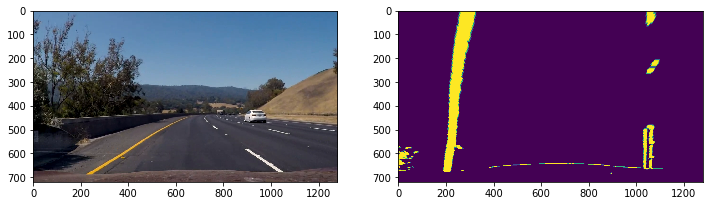

In [119]:
# Get prev fit
#img = mpimg.imread('./test_images/test6.jpg')
img = clip1.get_frame(25)
bin_warped = undistort(img)
bin_warped = get_binary(bin_warped)
bin_warped = birds_eye(bin_warped, src)
fig, ax = plt.subplots(1, 2, figsize=(12, 8))
ax[0].imshow(img)
ax[1].imshow(bin_warped)

left curve = 0.0018054669909938073
right curve = 0.0004739946757613984


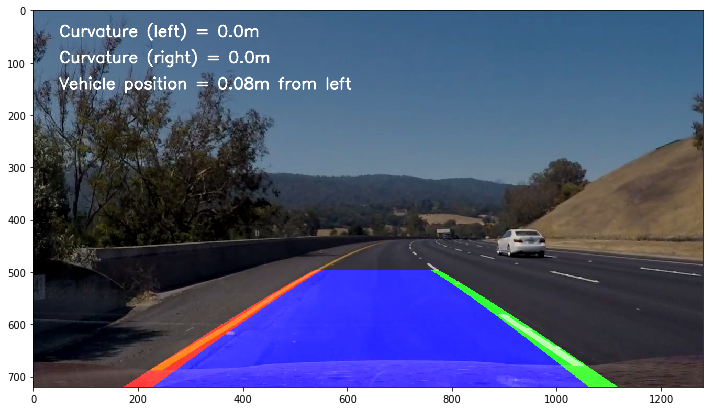

In [121]:
temp = fit_lane_curve(bin_warped)
# unpack
left_poly, right_poly, left_points, right_points, fitted_left_x, fitted_right_x, ploty, \
    left_curverad, right_curverad, skew_dir, skew_value = temp
print("left curve = {}".format(left_curverad))
print("right curve = {}".format(right_curverad))
overlay = make_overlay(img, fitted_left_x, fitted_right_x, ploty)
overlay = inverse_birds_eye(overlay, src)
final = weighted_img(overlay, img)
annotate(final, left_curverad, right_curverad, "{}m from {}".format(round(skew_value, 2), skew_dir))
fig, ax = plt.subplots(figsize=(12, 8))
plt.imshow(final)

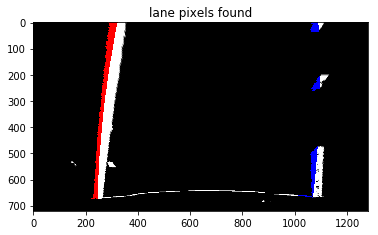

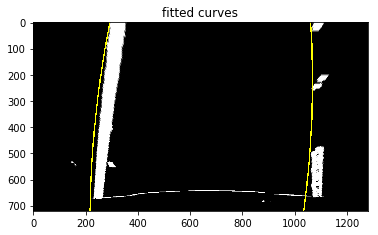

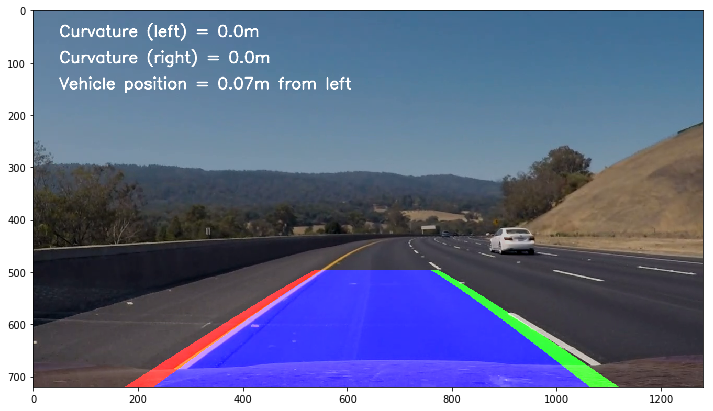

In [129]:
TEST_MARGIN = 30
# Get new image bebin
newImage = clip1.get_frame(26)
#newImage = mpimg.imread('./test_images/test4.jpg')
newUndst = undistort(newImage)
newBinary = get_binary(newUndst)
newBebin = birds_eye(newBinary, src)
newOut = fit_lane_curve(newBebin, 
                        left_poly, right_poly, 
                        left_points, right_points,
                        TEST_MARGIN, weight=0.1,
                        add_points_margin=None, draw_intermediate=True)
new_left_poly, new_right_poly, new_left_points, new_right_points,\
    fitted_left_x, fitted_right_x, ploty, left_curverad, right_curverad, skew_dir, skew_value = newOut
overlay = make_overlay(newImage, fitted_left_x, fitted_right_x, ploty)
overlay = inverse_birds_eye(overlay, src)
final = weighted_img(overlay, newImage)
annotate(final, left_curverad, right_curverad, "{}m from {}".format(round(skew_value, 2), skew_dir))
fig, ax = plt.subplots(figsize=(12, 8))
plt.imshow(final)

For a standout submission, you should follow the suggestion in the lesson to not just search blindly for the lane lines in each frame of video, but rather, once you have a high-confidence detection, use that to inform the search for the position of the lines in subsequent frames of video. For example, if a polynomial fit was found to be robust in the previous frame, then rather than search the entire next frame for the lines, just a window around the previous detection' could be searched. This will improve speed and provide a more robust method for rejecting outliers.

For an additional improvement you should implement outlier rejection and use a low-pass filter to smooth the lane detection over frames, meaning **add each new detection to a weighted mean of the position of the lines to avoid jitter.**

## Run your video

In [26]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [131]:
prev_left_poly, prev_right_poly = None, None
prev_left_points, prev_right_points = None, None

def process_image(image):
    
    # Set global versions
    global prev_left_poly
    global prev_right_poly
    global prev_left_points
    global prev_right_points
    global count
    
    # Params
    search_margin = 30
    new_weight = 0.2
    add_points_margin = None

    # Fix distort
    image = undistort(image)
    
    # Detect lanes
    cleaned = get_binary(image)
    cleaned = birds_eye(cleaned, src)
    out = fit_lane_curve(cleaned, 
                         prev_left_poly, prev_right_poly, 
                         prev_left_points, prev_right_points,
                         search_margin, new_weight,
                         add_points_margin)
    left_poly, right_poly, left_points, right_points,\
        fitted_left_x, fitted_right_x, ploty, \
        left_curverad, right_curverad, \
        skew_dir, skew_value = out

    
    # Prepare the final image
    overlay = make_overlay(image, fitted_left_x, fitted_right_x, ploty)
    overlay = inverse_birds_eye(overlay, src)
    final = weighted_img(overlay, image)
    annotate(final, left_curverad, right_curverad, "{}m from {}".format(round(skew_value, 2), skew_dir))
    
    # Reset the global variables
    prev_left_poly = left_poly
    prev_right_poly = right_poly
    prev_left_points = left_points
    prev_right_points = right_points
    
    return final

In [92]:
# bad_clip = VideoFileClip("project_video.mp4").subclip(20, 30)
# bad_clip.write_videofile("bad_clip.mp4", audio=False)

In [93]:
output_file = 'bad_clip_output.mp4'
clip1 = VideoFileClip("bad_clip.mp4")
input_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time input_clip.write_videofile(output_file, audio=False)

[MoviePy] >>>> Building video bad_clip_output.mp4
[MoviePy] Writing video bad_clip_output.mp4



 62%|██████▏   | 155/251 [01:03<00:40,  2.40it/s]


100%|█████████▉| 250/251 [01:43<00:00,  2.03it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: bad_clip_output.mp4 

CPU times: user 1min 13s, sys: 6.15 s, total: 1min 19s
Wall time: 1min 46s


In [94]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format('bad_clip_output.mp4'))

### Full original

In [103]:
output_file = 'project_output.mp4'
clip1 = VideoFileClip("project_video.mp4")#.subclip(20, 30)
input_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time input_clip.write_videofile(output_file, audio=False)

[MoviePy] >>>> Building video project_output.mp4
[MoviePy] Writing video project_output.mp4



 12%|█▏        | 152/1261 [01:00<07:33,  2.45it/s]


 24%|██▍       | 303/1261 [02:02<07:21,  2.17it/s]


 36%|███▌      | 454/1261 [03:04<05:32,  2.42it/s]


 48%|████▊     | 605/1261 [04:08<04:42,  2.32it/s]


 60%|█████▉    | 756/1261 [05:12<03:26,  2.45it/s]


 72%|███████▏  | 907/1261 [06:14<02:26,  2.42it/s]


 84%|████████▍ | 1057/1261 [07:19<01:34,  2.16it/s]


 96%|█████████▌| 1205/1261 [08:22<00:22,  2.46it/s]


100%|█████████▉| 1260/1261 [08:45<00:00,  2.41it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_output.mp4 

CPU times: user 6min 8s, sys: 30.7 s, total: 6min 38s
Wall time: 8min 47s


In [104]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format('project_output.mp4'))

### Challenge file

In [105]:
output_challenge = 'output_challenge.mp4'
clip2 = VideoFileClip("challenge_video.mp4") #.subclip(0, 5)
input_challenge = clip2.fl_image(process_image) #NOTE: this function expects color images!!
%time input_challenge.write_videofile(output_challenge, audio=False)

[MoviePy] >>>> Building video output_challenge.mp4
[MoviePy] Writing video output_challenge.mp4



 29%|██▉       | 143/485 [00:55<02:18,  2.46it/s]


TypeError: expected non-empty vector for x

In [108]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format('challenge_video.mp4'))

### Even harder challenge ):

In [112]:
output_harder = 'output_harder.mp4'
clip3 = VideoFileClip("harder_challenge_video.mp4") #.subclip(0, 5)
input_harder = clip3.fl_image(process_image) #NOTE: this function expects color images!!
%time input_harder.write_videofile(output_harder, audio=False)

[MoviePy] >>>> Building video output_harder.mp4
[MoviePy] Writing video output_harder.mp4


100%|█████████▉| 1199/1200 [08:38<00:00,  2.25it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_harder.mp4 

CPU times: user 5min 50s, sys: 24.4 s, total: 6min 15s
Wall time: 8min 42s


In [6]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format('output_harder.mp4'))